# Time-series analysis of Brazil's average temperature

In this project we are going to analyze Brazil's average surface temperature starting from the end of the 19th century to the beginning of the 21st century. The dataset (available in [Kaggle](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)) contains monthly measurements of average temperature for different countries and major cities.

Our goal is to study the periodicity of the temperature using seasonal decomposition and to develop a prediction for the next years using SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model). We also make a projection for the average temperature in 2050 using linear regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

# Set plotting parameters
import matplotlib
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.linewidth']=1
matplotlib.rcParams['figure.figsize']=[15,6]
matplotlib.rcParams['legend.fontsize']=16

In [2]:
# Read the data
df=pd.read_csv('data/GlobalLandTemperaturesByCountry.csv',usecols=['dt','AverageTemperature','Country'])

# Select data for Brazil
df=df[df.Country=='Brazil']
df.drop(columns='Country',inplace=True)

# Define date as index
df.dt=pd.to_datetime(df.dt)
df.columns=['Date','AverageTemperature']
df.set_index('Date',inplace=True)

df.head()

,AverageTemperature
Date,
1832-01-01,24.935
1832-02-01,24.505
1832-03-01,24.617
1832-04-01,23.990
1832-05-01,23.124


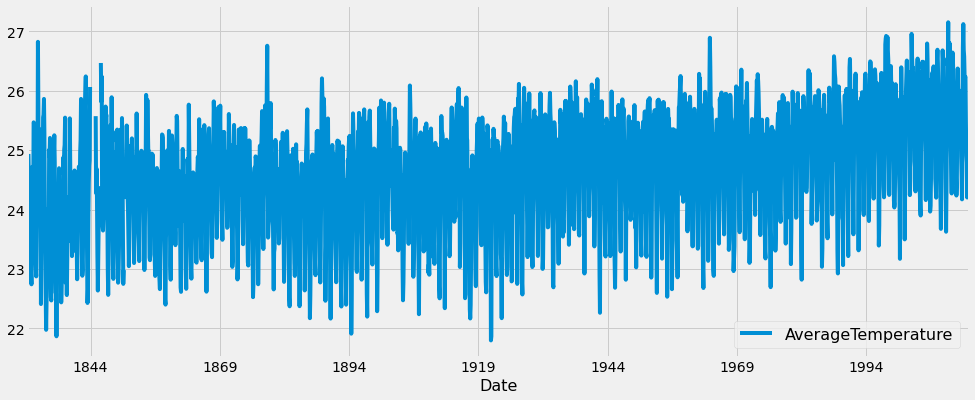

In [3]:
# Plot the data
df.plot()
plt.savefig('raw_plot.png')

In [4]:
# Check for NaN values
df.isna().sum()

AverageTemperature    17
dtype: int64

In [5]:
# Fill NaN values using forward fill
df.fillna(method='ffill',inplace=True)
# Resample data to montlhy average
df=df.resample('MS').mean()

In [6]:
# Check for NaN again
df.isna().sum()

AverageTemperature    0
dtype: int64

In [9]:
# Create a function to study the stationarity of the dataset: 'test_stationarity' prints the results
# from the ADF test and makes a plot comparing the data to its rolling mean/std
# Series is stationary if p<0.05 and stats<critical value

from statsmodels.tsa.stattools import adfuller

def test_stationarity(df,var,window):
    adfTest=adfuller(df[var])
    stats=pd.Series(adfTest[0:4],index=['Test stat','p-value','#lags used','#observations used'])
    print(stats)
    for key,values in adfTest[4].items():
        print('criticality at',key,':',values)
    
    dfcopy=df.copy(deep=True)
    dfcopy['rollMean']=df[var].rolling(window=window).mean()
    dfcopy['rollStd']=df[var].rolling(window=window).std()
    dfcopy[var].plot(label='Data')
    dfcopy.rollMean.plot(label='Rolling mean',linewidth=3)
    dfcopy.rollStd.plot(label='Rolling std',linewidth=3)
    plt.legend()
    plt.savefig('test_stationarity.png')
    plt.show()

Test stat               -3.439203
p-value                  0.009693
#lags used              26.000000
#observations used    2154.000000
dtype: float64
criticality at 1% : -3.4333895125643408
criticality at 5% : -2.86288274571734
criticality at 10% : -2.567484811553121


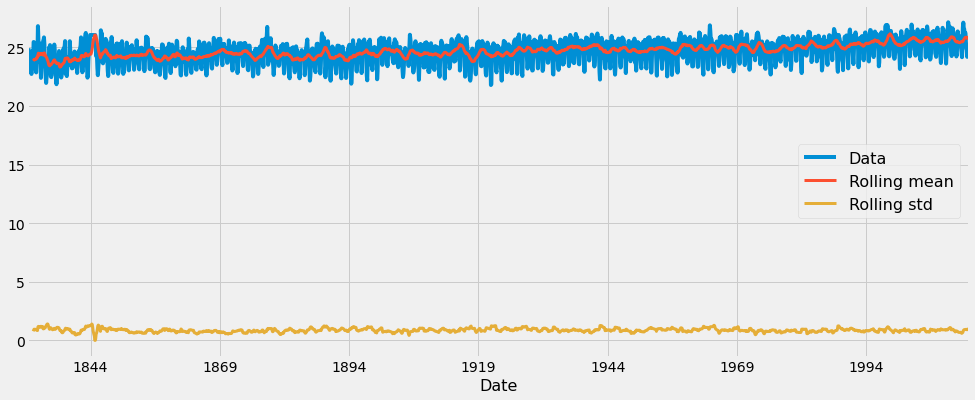

In [10]:
# Apply the stationarity test for the whole dataset

test_stationarity(df,'AverageTemperature',12)

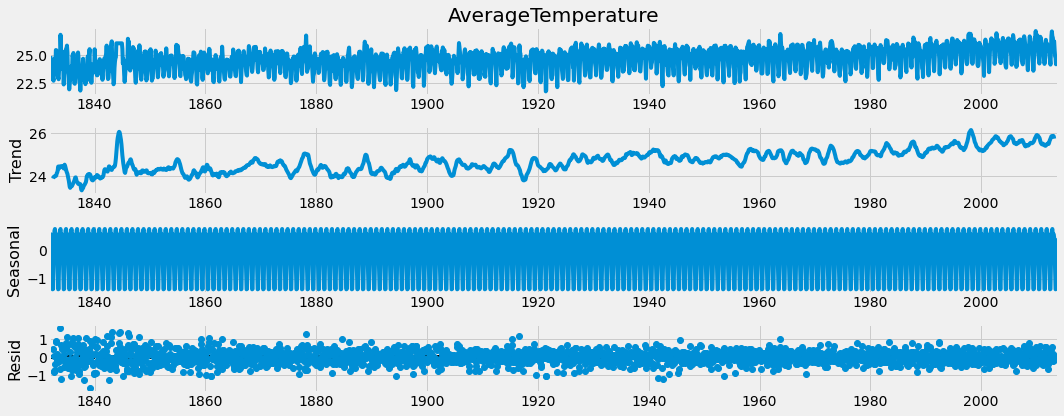

In [11]:
# Seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.AverageTemperature, model='additive')
fig = decomposition.plot()
plt.savefig('seasonal_decomp.png')
plt.show()

In [12]:
# Generate a list of tuples representing all possible combinations of (p, d, q) where each 
# element of the tuple is either 0 or 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# The same, but the last value is 12 (= seasonality window)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
# Calculate AIC (Akaike Information Criteria) for different combinations of p,d,q

performance_table=np.zeros( ( len(pdq),len(seasonal_pdq) ) )

for i_param in range(len(pdq)):
    for i_param_seasonal in range(len(seasonal_pdq)):
        try:
            param=pdq[i_param]
            param_seasonal=seasonal_pdq[i_param_seasonal]
            
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            performance_table[i_param,i_param_seasonal]=results.aic
        except:
            continue

/home/rafaellraiser/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rafaellraiser/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Display optimal values of p,d,q (values that minimize AIC)

i_min,j_min = np.unravel_index(performance_table.argmin(), performance_table.shape)
print('Optimal parameters: {}x{} AIC:{}'.format( pdq[i_min], seasonal_pdq[j_min], performance_table[i_min,j_min] ) )

Optimal parameters: (1, 0, 1)x(0, 1, 1, 12) AIC:2162.642825927547


In [15]:
# Perform SARIMAX and print the results

mod = sm.tsa.statespace.SARIMAX(df,
                                order=pdq[i_min],
                                seasonal_order=seasonal_pdq[j_min],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8297      0.017     47.704      0.000       0.796       0.864
ma.L1         -0.4401      0.028    -15.709      0.000      -0.495      -0.385
ma.S.L12      -0.9199      0.009    -99.934      0.000      -0.938      -0.902
sigma2         0.1580      0.004     42.899      0.000       0.151       0.165


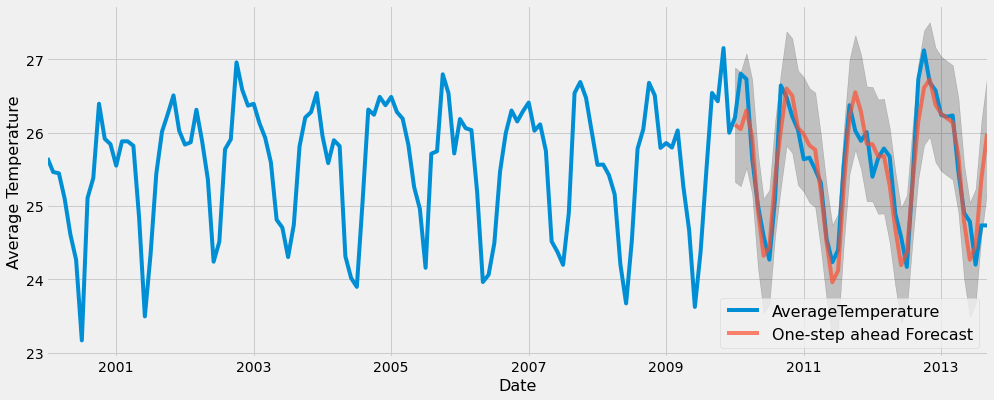

In [17]:
# Plot original data starting from 2000 alongside SARIMAX predictions from 2010 and respective confidence interval

pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2000-01-01':].plot(label='Observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature')
plt.legend()
plt.savefig('sarimax_observed_vs_results.png')
plt.show()

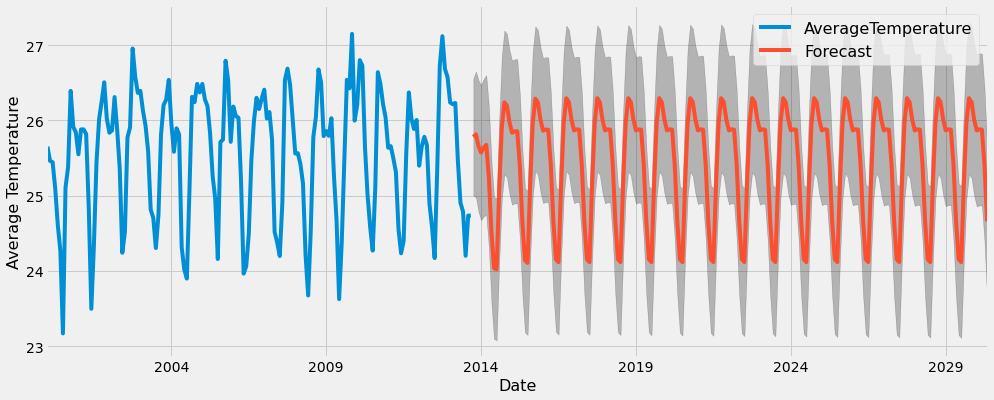

In [18]:
# Plot the forecast for the next 200 months according to SARIMAX 

pred_uc = results.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = df['2000-01-01':].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature')
plt.legend()
plt.savefig('sarimax_forecast.png')
plt.show()

<ipython-input-19-33a59eb095a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df90s['Days since start']=(df90s.index-df90s.index[0]).days


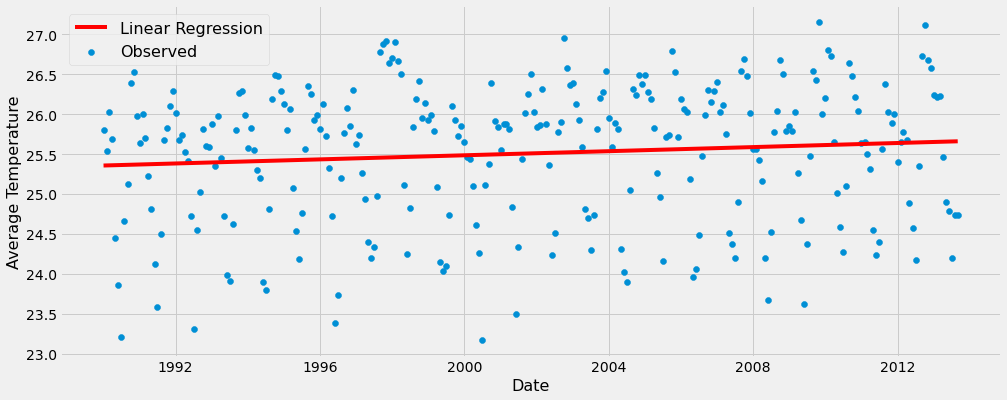

In [19]:
# Perform a linear regression using data starting from year 1990 and plot the result

df90s=df['1990-01-01':]

df90s['Days since start']=(df90s.index-df90s.index[0]).days

x=df90s['Days since start'].values.reshape(-1,1)
y=df90s.AverageTemperature.values.reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

predictions = model.predict(x)

plt.scatter(df90s.index, y, label='Observed')
plt.plot(df90s.index, predictions, color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()

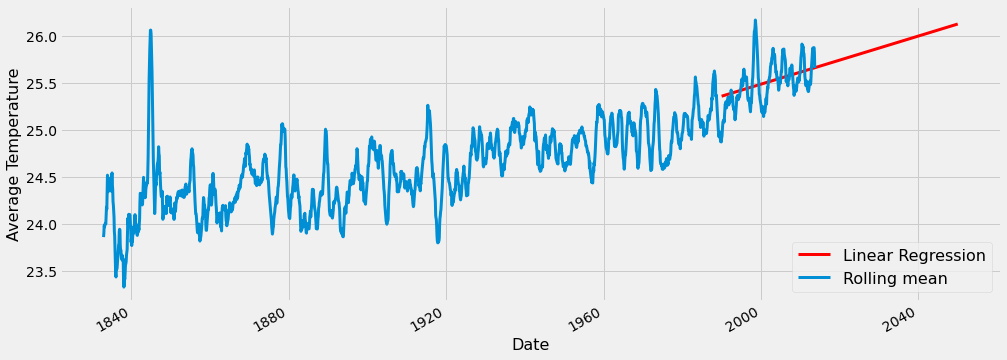

In [20]:
# Plot rolling mean and linear regression

x_fit=[[(pd.to_datetime('2050-01-01')-pd.to_datetime('1990-01-01')).days],[0]]
y_fit=model.predict(x_fit)

dfcopy=df.copy(deep=True)
dfcopy['rollMean']=df.AverageTemperature.rolling(window=12).mean()

plt.plot([pd.to_datetime('2050-01-01'),pd.to_datetime('1990-01-01')], y_fit, color='red', label='Linear Regression',linewidth=3)

dfcopy.rollMean.plot(label='Rolling mean',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.savefig('average_linearfit.png')
plt.show()


In [21]:
# Print predicted average temperature for 2050 using linear regression

T2050=model.predict( [x_fit[0]] )[0,0]
print('Predicted average temperature at 2050: {} deg C'.format(round(T2050,1)))

Predicted average temperature at 2050: 26.1 deg C
